## Finding the Optimal Topic Count

Source: https://stackoverflow.com/questions/32313062/what-is-the-best-way-to-obtain-the-optimal-number-of-topics-for-a-lda-model-usin

In [1]:
from pprint import pprint
import numpy as np

import json
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from nltk.corpus import stopwords
import gensim
import gensim.corpora as corpora
import gensim.models.ldamodel as lda
import spacy
import itertools

import pandas as pd
import sqlite3

import re
import unidecode as ud
import pickle
import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from ArtistReviewAnalyzer import ArtistReviewAnalyzer

/Users/celinechoo/.pyenv/versions/3.7.6/envs/singerenv/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
def jaccard_similarity(topic_1, topic_2):
    """
    Derives the Jaccard similarity of two topics

    Jaccard similarity:
    - A statistic used for comparing the similarity and diversity of sample sets
    - J(A,B) = (A ∩ B)/(A ∪ B)
    - Goal is low Jaccard scores for coverage of the diverse elements
    """
    intersection = set(topic_1).intersection(set(topic_2))
    union = set(topic_1).union(set(topic_2))
                    
    return float(len(intersection))/float(len(union))

In [3]:
pf_file = "../../data/processed/artist_reviews_pf_only.json"

In [4]:
pf = ArtistReviewAnalyzer()
pf.build(file_loc=pf_file, min_df=300, max_df=0.6)

In [5]:
num_topics = list(range(16)[1:])
num_keywords = 15

LDA_models = {}
LDA_topics = {}
for i in num_topics:
    LDA_models[i] = pf.run_lda_model(num_topics=i)
    shown_topics = LDA_models[i].show_topics(num_topics=i, 
                                             num_words=num_keywords,
                                             formatted=False)
    LDA_topics[i] = [[word[0] for word in topic[1]] for topic in shown_topics]

In [6]:
for i in LDA_topics:
    print(LDA_topics[i])
    print()
    print()

[['be', 'have', 'album', 'song', 'do', 's', 'more', 'sound', 'make', 'band', 'record', 'track', 'get', 'most', 'music']]


[['be', 'have', 'song', 'album', 'band', 'do', 'more', 's', 'sound', 'make', 'record', 'music', 'most', 'so', 'track'], ['be', 'have', 's', 'do', 'album', 'more', 'song', 'make', 'rap', 'get', 'sound', 'track', 'when', 'just', 'most']]


[['be', 'have', 'song', 'album', 'band', 'do', 'more', 'sound', 's', 'record', 'make', 'music', 'track', 'most', 'so'], ['be', 'have', 's', 'do', 'album', 'rap', 'more', 'make', 'get', 'sound', 'track', 'song', 'when', 'most', 'just'], ['be', 'have', 'song', 'do', 'album', 's', 'band', 'more', 'sound', 'make', 'pop', 'get', 'track', 'just', 'record']]


[['be', 'have', 'song', 'album', 'band', 'do', 'more', 'sound', 's', 'record', 'make', 'music', 'rock', 'so', 'most'], ['be', 'have', 's', 'do', 'album', 'rap', 'more', 'make', 'sound', 'song', 'get', 'track', 'when', 'even', 'just'], ['be', 'have', 'do', 'song', 'album', 's', 'more

In [7]:
LDA_stability = {}
for i in range(0, len(num_topics)-1):
    jaccard_sims = []
    for t1, topic1 in enumerate(LDA_topics[num_topics[i]]): 
        sims = []
        for t2, topic2 in enumerate(LDA_topics[num_topics[i+1]]): 
            sims.append(jaccard_similarity(topic1, topic2))    
        
        jaccard_sims.append(sims)    
    
    LDA_stability[num_topics[i]] = jaccard_sims
                
mean_stabilities = [np.array(LDA_stability[i]).mean() for i in num_topics[:-1]]

In [9]:
id2word = corpora.Dictionary(pf.tokenized_reviews)
corpus = [id2word.doc2bow(w) for w in pf.tokenized_reviews]

coherences = [gensim.models.CoherenceModel(model=LDA_models[i], texts=pf.tokenized_reviews, dictionary=id2word, coherence='c_v').get_coherence()\
              for i in num_topics[:-1]]

In [10]:
coh_sta_diffs = [coherences[i] - mean_stabilities[i] for i in range(num_keywords)[:-1]] # limit topic numbers to the number of keywords
coh_sta_max = max(coh_sta_diffs)
coh_sta_max_idxs = [i for i, j in enumerate(coh_sta_diffs) if j == coh_sta_max]
ideal_topic_num_index = coh_sta_max_idxs[0] # choose less topics in case there's more than one max
ideal_topic_num = num_topics[ideal_topic_num_index]

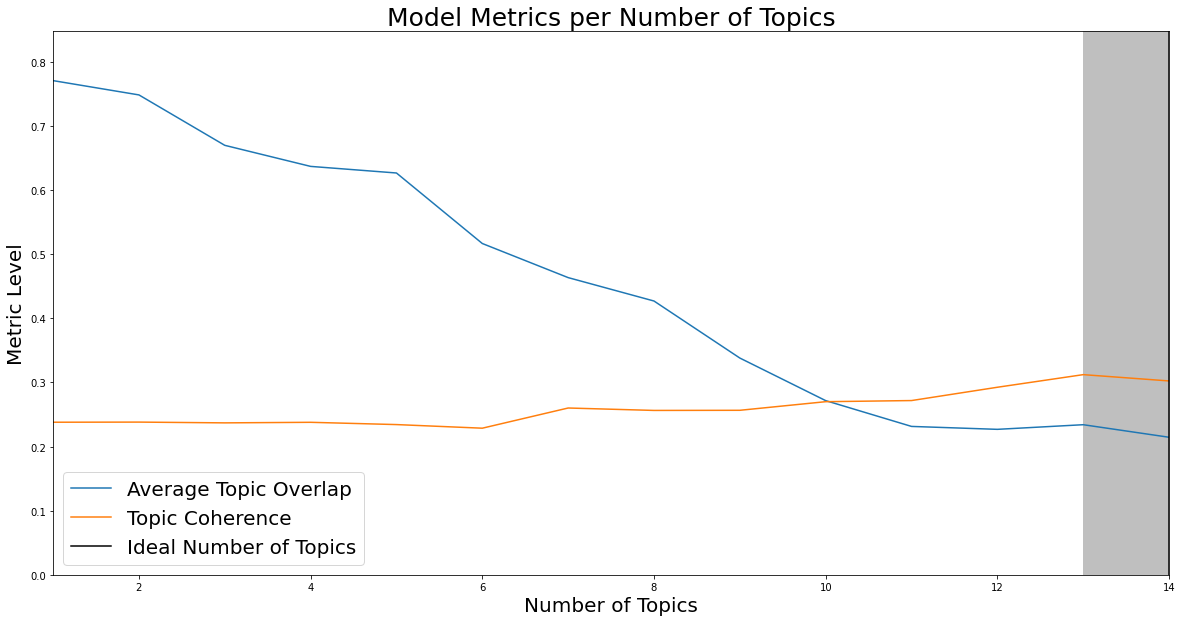

In [11]:
plt.figure(figsize=(20,10))
ax = sns.lineplot(x=num_topics[:-1], y=mean_stabilities, label='Average Topic Overlap')
ax = sns.lineplot(x=num_topics[:-1], y=coherences, label='Topic Coherence')

ax.axvline(x=ideal_topic_num, label='Ideal Number of Topics', color='black')
ax.axvspan(xmin=ideal_topic_num - 1, xmax=ideal_topic_num + 1, alpha=0.5, facecolor='grey')

y_max = max(max(mean_stabilities), max(coherences)) + (0.10 * max(max(mean_stabilities), max(coherences)))
ax.set_ylim([0, y_max])
ax.set_xlim([1, num_topics[-1]-1])
                
ax.axes.set_title('Model Metrics per Number of Topics', fontsize=25)
ax.set_ylabel('Metric Level', fontsize=20)
ax.set_xlabel('Number of Topics', fontsize=20)
plt.legend(fontsize=20)
plt.show()

In [12]:
# Load pitchfork descriptors
pf_desc = {}
with open('../pitchfork_descriptors.json', 'r') as infile:
    pf_desc = json.load(infile)

print(len(pf_desc.keys()))

1201
